## Visualizing results -  SpaCy Geotagger + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of a particular book, and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

The book that we have used for this experiment is the **First Edition, Volume 1, A-B** (year 1771) of the *Encyclopaedia Britannica*, which has 832 pages.
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_subsample.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_144133901' -n 16`

The nls_subsample.txt has the path of this particular book that we are exploring:

`xxx/nls-data-encyclopaediaBritannica/144133901`

And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`

The results file ( [georesolution_en_core_web_lg_EB_144133901](http://localhost:8888/edit/results_NLS/georesolution_en_core_web_lg_EB_144133901) ) is stored in this repository under the *results_NLS* subdirectory. 

Note: We just perfomed this study using all the pages of one boo. But we could run this query using the full EB dataset.


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def display_spacy_entities(result):
    for i in result.keys():
        for k in result[i]:
            html= k["display_doc"]
            if html:
                print(" \n ----- %s: Entities with the Spacy \"%s\" language model  ----- \n" % (k["text_unit id"], k["lang_model"]))
                display(HTML(html))

In [4]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [5]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [6]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        if place_name not in filter_list:
            print(i, place_count,place_name)
            place_label.append(place_name)
            place_freq.append(place_count)
            k = k + 1
        i = i + 1
    return place_label, place_freq

In [7]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq, color = 'green')
    plt.xlabel('Places', fontsize=10)
    plt.ylabel('Frequency of Places', fontsize=5)
    plt.xticks(index, place_label, fontsize=8, rotation=40)
    plt.title('15 Places most mentioned using SpaCy and the Georesolver')
    plt.savefig('SpaCy1stbook1stEdition.png', dpi=300)

### Information about the defoe georesolution query

This query does the following tasks:

- Ingests all the pages from the directory "144133901",  which corresponds to the book "Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * display_doc: HTML string with the name entities detected by spacy for each page
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. In this case, number of pages of this particular book (e.g. 832)
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (e.g. en_core_web_lg)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


Example:
  - archive_filename: /home/tdm/datasets/encyclopaedia-britannica-sample/144133901
  - clean_text: "ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent
    SCIENCES and ARTS are dioefted into " O diflinct Treatifes or Syitems; AND . The
    \irious TECHNIC A LTERMS, <&C. are explained as they occur in the order of the
    Alphabet. ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERPLATES. fry a SOCIETY of
    GENTLEMEN in SCOTLAND .... "
  - display_doc:"<div class=\"entities\" style=\"line-height: 2.5; direction: ltr\"\
    >ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent SCIENCES\
    \ and ARTS .... "
  - edition: First edition, 1771, Volume 1, A-B
  - georesolution_page:
    SCOTLAND-rb3:
        - '56'
        - '-4'
  - lang_model: en_core_web_lg
  - model: nls
  - num_text_unit: 832
  - page_filename: alto/188082826.34.xml
  - place: Edinburgh
  - text_unit: page
  - text_unit id: Page9
  - type_distribution: book
  - year: 1771



In [8]:
results=read_query_results('georesolution_en_core_web_lg_EB_144133901')

In [9]:
#display_spacy_entities(results)

In [10]:
df_total= geresolution_dataframe(results)

In [11]:
df_total[["Place"]].count()

Place    4006
dtype: int64

In [12]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
2190,1,1,1
ABERDEEN,1,1,1
ABU SAN,1,1,1
ACAPULCO,1,1,1
AFRICA,1,1,1
AGADES,1,1,1
AGRA,1,1,1
AGRAM,1,1,1
ALBANY,1,1,1


In [13]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page100,10,10,10
Page101,33,33,33
Page102,20,20,20
Page103,32,32,32
Page105,30,30,30
Page106,28,28,28
Page109,19,19,19
Page110,20,20,20
Page111,11,11,11


In [14]:
df_total.groupby(["Latitude", "Longitude"]).count()

Place  Page
Latitude  Longitude              
-0.22985  -78.52495       1     1
-1.25     -78.25          1     1
-1.31367  36.77854        1     1
-1.43365  -80.51061       2     2
-1.59389  16.04389        1     1
-10       -55            11    11
          -75.25         13    13
          70              1     1
-12.04318 -77.02824       2     2
-12.05659 -77.11814       1     1
-12.5     18.5            2     2
-13       -56             1     1
-14.56667 35.71667        1     1
-14.60485 -57.65625      13    13
-14.83333 -64.9           1     1
-15.40669 28.28713        1     1
-16.44972 -39.06472       1     1
-17.27556 37.58556        1     1
-17.98333 20.78333        5     5
-18.25    35              1     1
-19.84361 34.83889        1     1
-2.71024  132.16831       1     1
-20.37778 -43.41611       1     1
-23.2325  -51.66556       1     1
-23.33333 -58             2     2
-25.59971 23.40573        1     1
-26.13957 152.74833       1     1
-26.81427 -54.34387       1     1
-27.60709 151.96688       1     1
-27.80828 25.73835        4     4
...                     ...   ...
6.78234   -75.56191       1     1
60        100             5     5
60.10867  -113.64258      7     7
60.41667  24.75           1     1
60.6      -1.1            1     1
61.1433   54.36585        1     1
61.21806  -149.90028      2     2
61.60513  -6.95063        1     1
62        10              9     9
          15             20    20
63.20215  -145.50877      1     1
63.71239  10.72638        1     1
64        26              3     3
64.36285  11.24425        1     1
65        -15             4     4
          -18             3     3
7.00167   -75.03833       1     1
7.15932   171.21119       1     1
7.1881    21.09375       82    82
7.44483   4.11346         1     1
7.75      80.75           1     1
8         -66             1     1
8.29184   0.60972         1     1
8.5       -11.5           1     1
9         39.5           19    19
9.33068   -75.17701       1     1
9.45472   6.76377         1     1
9.5       2.25            1     1
9.56487   -75.28223       1     1
9.8723    -74.31032       2     2

[1014 rows x 2 columns]

In [15]:
df_max_geolocations = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     


df_max_geolocations.head(10)

,Latitude,Longitude,count
262,34.23314,-102.41075,593
730,46,2,126
790,48.69096,9.14062,98
165,26.93422,-80.09421,94
1002,7.1881,21.09375,82
613,42.83333,12.83333,76
82,14.32995,120.92934,76
967,56,-4,75
872,51.43667,5.97917,71
956,54.75844,-2.69531,69


In [16]:
#Getting the 15 places (and their frequencies) most mentioned - filtering some elements
filter_list=['earth', 'the moon', 'Jupiter']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)

1 126 France
2 98 Europe
4 82 Africa
5 76 Italy
7 75 SCOTLAND
8 71 America
9 69 Britain
10 65 Germany
11 61 Spain
12 57 London
13 54 England
15 47 Rome
16 44 Asia
17 33 Egypt
18 30 India


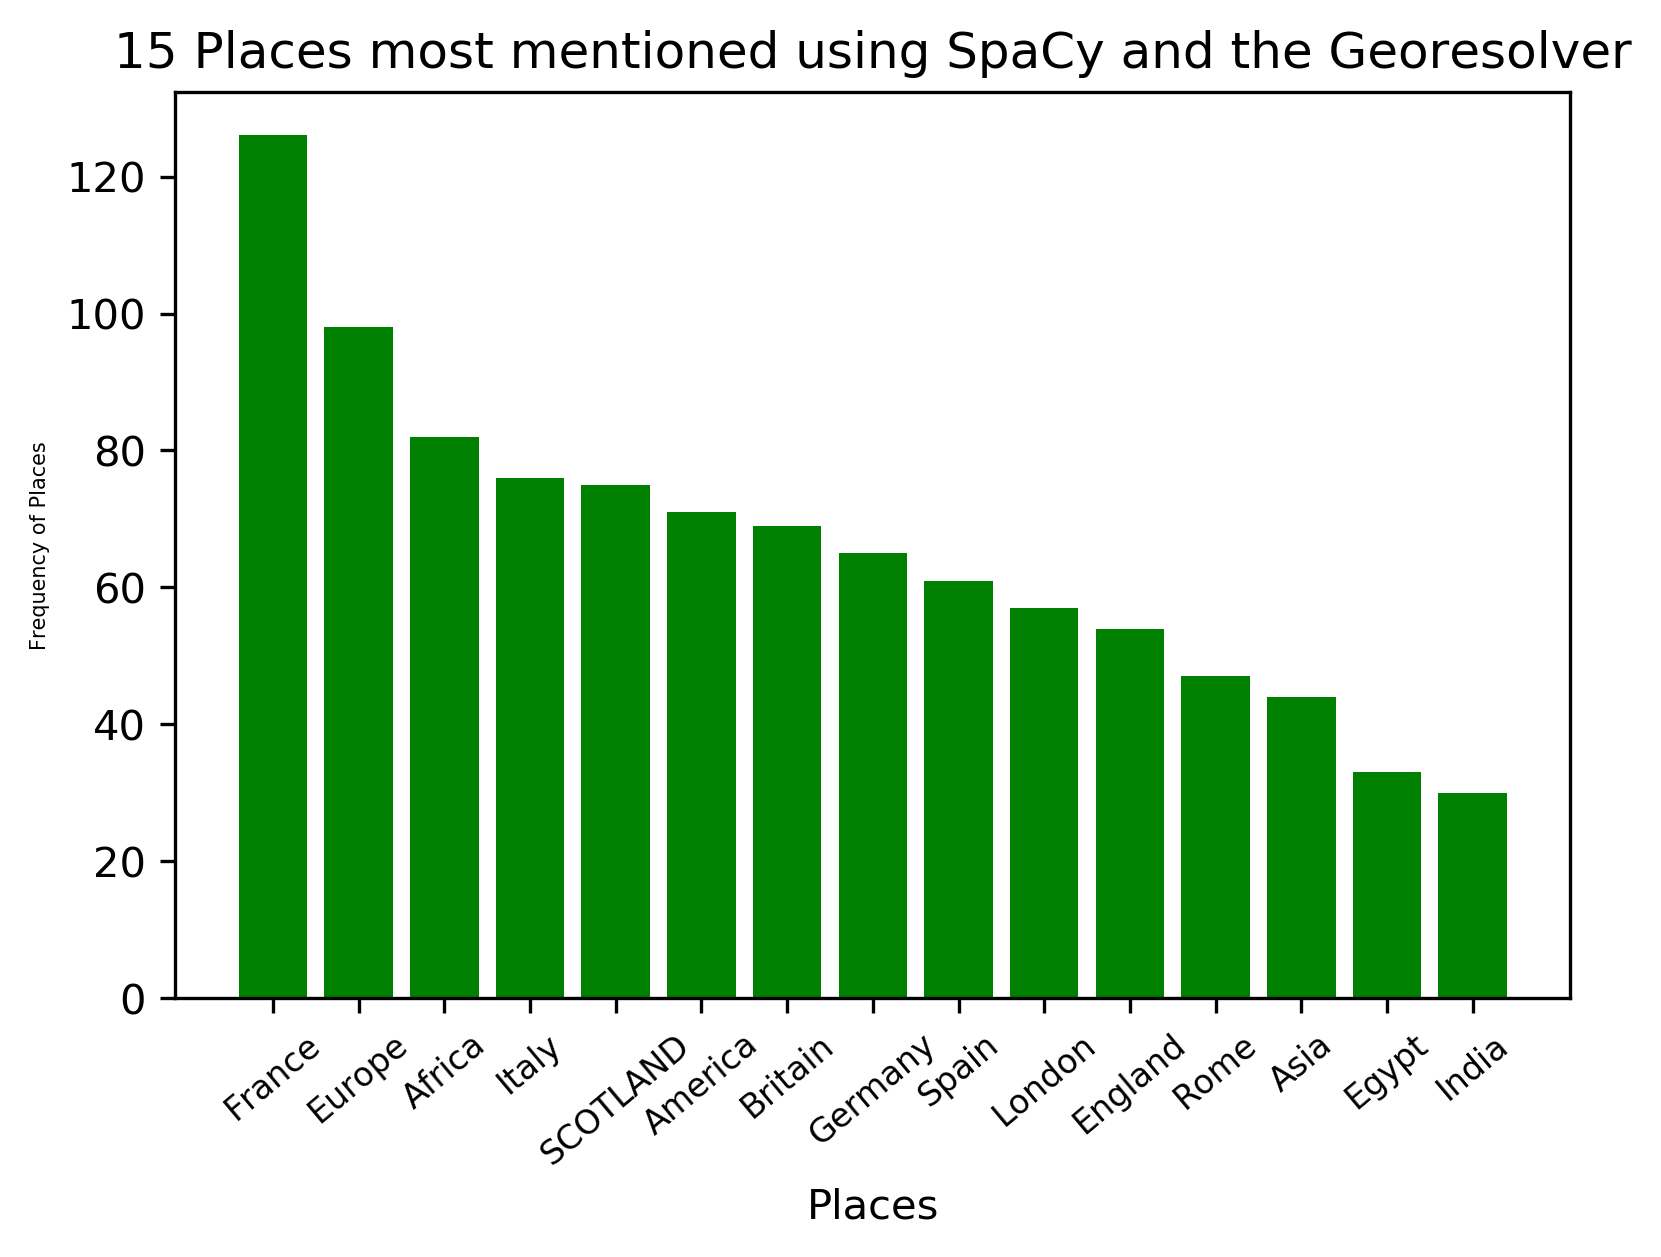

In [17]:
#Visualizing the 15 places in a Bar plot
mpl.rcParams['figure.dpi']=300
plot_bar_places(place_label, place_freq)

In [18]:
df_total.sum()

Latitude     5628.750545618.3807836.4884743.9522143.1467518...
Longitude    -4-82.5001-4-65.95739-79.7667-103.44575-71.457...
Place        SCOTLANDFloridaScotlandCarolinaEdenCalmetPembr...
Page         Page9Page13Page13Page13Page13Page13Page14Page1...
dtype: object